In [1]:
import sys, os, importlib

# --- Paths ---
current_dir = os.getcwd()  # This will be .../DeepOMAPNet/Notebooks
project_root = os.path.dirname(current_dir)  # This will be .../DeepOMAPNet

# Add project root to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Added to Python path:")
print(f"- Current directory: {current_dir}")
print(f"- Project root: {project_root}")
print(f"- Scripts directory exists: {os.path.exists(os.path.join(project_root, 'scripts'))}")
print(f"- Scripts/data_provider exists: {os.path.exists(os.path.join(project_root, 'scripts', 'data_provider'))}")

# Clear any cached imports
importlib.invalidate_caches()

# --- Import modules (module-style, not from ... import ...) ---
import scripts.data_provider.data_preprocessing as data_preprocessing
import scripts.data_provider.graph_data_builder as graph_data_builder
import scripts.model.doNET as doNET
import scripts.trainer.gat_trainer as gat_trainer

print("Module imports successful!")

Added to Python path:
- Current directory: /projects/vanaja_lab/satya/DeepOMAPNet/Tutorials
- Project root: /projects/vanaja_lab/satya/DeepOMAPNet
- Scripts directory exists: True
- Scripts/data_provider exists: True


/home/nandivada.s/.conda/envs/scvi-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Module imports successful!


In [2]:
import scanpy as sc
GSE559 = sc.read_h5ad("/projects/vanaja_lab/satya/DeepOMAPNet/GSE232559.h5ad")
GSE559


AnnData object with n_obs × n_vars = 29925 × 2000
    obs: 'sample', 'UMAP_1', 'UMAP_2', 'totalvi_1', 'totalvi_2', 'totalvi_3', 'totalvi_4', 'totalvi_5', 'totalvi_6', 'totalvi_7', 'totalvi_8', 'totalvi_9', 'totalvi_10', 'totalvi_11', 'totalvi_12', 'totalvi_13', 'totalvi_14', 'totalvi_15', 'totalvi_16', 'totalvi_17', 'totalvi_18', 'totalvi_19', 'totalvi_20', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p'
    obsm: 'X_scVI'
    layers: 'counts'

In [3]:
import pandas as pd
import numpy as np
import gzip
from scipy import io
import scanpy as sc

# 1. Read protein (ADT) features
with gzip.open('/projects/vanaja_lab/satya/Datasets/GSE232559/GSE232559_totalvi_denoised_adt_features.tsv.gz', 'rt') as f:
    features = pd.read_csv(f, sep='\t', header=None)[0].tolist()

# 2. Read ADT matrix (features x cells)
with gzip.open('/projects/vanaja_lab/satya/Datasets/GSE232559/GSE232559_totalvi_denoised_adt.mtx.gz', 'rt') as f:
    mtx = io.mmread(f)


df = pd.DataFrame(mtx.T.toarray(), columns=features)

# ------------------- NEW STEP: EXTRACT AS DATAFRAME -------------------
# If you've already assigned, this works for any AnnData in this format:

# Extract the protein matrix as a DataFrame with proper labels
protein_df = pd.DataFrame(
    df.iloc[:29925].values, 
    index=GSE559.obs_names,                 # Cells as rows
    columns=df.columns     # Proteins as columns
)




In [4]:
def zscore_normalize(X):
    # X: 2D numpy array of shape (n_samples, n_features)
    import numpy as np

    # Make a copy to avoid modifying original data
    X = X.copy()

    # Check for NaN values
    if np.any(np.isnan(X)):
        print(f"Warning: Found {np.sum(np.isnan(X))} NaN values before z-score normalization.")
        # Replace NaN with 0
        X = np.nan_to_num(X, nan=0.0)

    # Calculate mean and std for each feature (column)
    means = np.nanmean(X, axis=0, keepdims=True)
    stds = np.nanstd(X, axis=0, keepdims=True) + 1e-8  # Add epsilon

    # Handle std == 0
    stds = np.where(stds == 0, 1.0, stds)

    # Z-score normalize
    X_zscore = (X - means) / stds

    # Replace any remaining NaN or inf values with 0
    X_zscore = np.nan_to_num(X_zscore, nan=0.0, posinf=0.0, neginf=0.0)

    return X_zscore, means, stds


In [5]:
import numpy as np
import pandas as pd

# CLR normalization function
def clr_normalize(df):
    pseudocount = 1e-6
    log_df = np.log1p(df + pseudocount)
    clr_df = log_df.sub(log_df.mean(axis=1), axis=0)
    return clr_df

# Z-score normalization function (expects a numpy array)
def zscore_normalize(X):
    X = X.copy()
    if np.any(np.isnan(X)):
        print(f"Warning: Found {np.sum(np.isnan(X))} NaN values before z-score normalization.")
        X = np.nan_to_num(X, nan=0.0)
    means = np.nanmean(X, axis=0, keepdims=True)
    stds = np.nanstd(X, axis=0, keepdims=True) + 1e-8
    stds = np.where(stds == 0, 1.0, stds)
    X_zscore = (X - means) / stds
    X_zscore = np.nan_to_num(X_zscore, nan=0.0, posinf=0.0, neginf=0.0)
    return X_zscore, means, stds

# Assuming protein_df is your original DataFrame of shape (n_cells, n_proteins)

# Step 1: CLR normalization
protein_df_clr = clr_normalize(protein_df)

# Step 2: Convert CLR DataFrame to numpy array and apply z-score normalization
protein_clr_np = protein_df_clr.values
protein_clr_zscore, means, stds = zscore_normalize(protein_clr_np)

# Optional: convert back to DataFrame with original row and column labels
protein_clr_zscore_df = pd.DataFrame(protein_clr_zscore, index=protein_df_clr.index, columns=protein_df_clr.columns)

# View the z-score normalized DataFrame
print(protein_clr_zscore_df)


                                CD4       CD7      CD56       CD3      CD33  \
barcode                                                                       
AML-03_AAAGAACAGGTGCCTC   -0.229186  0.342693  0.055530 -0.237099  0.274873   
AML-03_AAAGAACCAACGGCTC   -0.895321  0.815409 -0.095282 -0.202494 -0.163403   
AML-03_AAAGAACGTATTGGCT   -0.527390  0.648787 -0.008643 -0.215522  0.315426   
AML-03_AAAGGATAGACATATG   -0.498040  0.529621 -0.282048 -0.348133  0.261310   
AML-03_AAAGGGCAGGTTCATC   -0.660125  0.533740 -0.007893 -0.186009  0.299604   
...                             ...       ...       ...       ...       ...   
Pt-89_Dx_TTTCCTCTCCTTGACC  2.846396  2.058115  0.767851  3.292323 -3.021813   
Pt-89_Dx_TTTGACTAGGTGCATG  2.988849  2.061277  0.891137  3.329386 -2.858095   
Pt-89_Dx_TTTGATCGTCACCGCA  0.469184 -0.977875  0.264462 -0.254841  1.036657   
Pt-89_Dx_TTTGATCTCAAACGAA -0.159409 -0.001521  0.013587 -0.307108  0.553389   
Pt-89_Dx_TTTGTTGGTCTTGAAC -0.667268  0.518241 -0.217

In [8]:
# Randomly select 10,000 cell indices (rows)
selected_indices = np.random.choice(GSE559.n_obs, size=10000, replace=False)

# Subset the AnnData object
GSE559 = GSE559[selected_indices].copy()

print(GSE559)

AnnData object with n_obs × n_vars = 10000 × 2000
    obs: 'sample', 'UMAP_1', 'UMAP_2', 'totalvi_1', 'totalvi_2', 'totalvi_3', 'totalvi_4', 'totalvi_5', 'totalvi_6', 'totalvi_7', 'totalvi_8', 'totalvi_9', 'totalvi_10', 'totalvi_11', 'totalvi_12', 'totalvi_13', 'totalvi_14', 'totalvi_15', 'totalvi_16', 'totalvi_17', 'totalvi_18', 'totalvi_19', 'totalvi_20', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p'
    obsm: 'X_scVI'
    layers: 'counts'


In [6]:
# Convert AnnData to PyTorch Geometric format
print("=== Converting to PyTorch Geometric Format ===")
from scripts.data_provider.graph_data_builder import build_pyg_data
# Convert RNA data
print("Converting RNA data...")
rna_pyg_data = build_pyg_data(GSE559)
print(f"RNA PyG data: {rna_pyg_data}")




=== Converting to PyTorch Geometric Format ===
Converting RNA data...
build_pyg_data called with use_pca=True
Input adata shape: (29925, 2000)
Available obsm keys: ['X_scVI']
Computing PCA with exactly 50 components...
PCA computed, shape: (29925, 50)
Computing neighbor graph first...
Computing leiden clusters first...
Using PCA features, shape: (29925, 50)
RNA PyG data: Data(x=[29925, 50], edge_index=[2, 337028], y=[29925])


In [7]:
import torch
import sys
import os
from scripts.model.doNET import GATWithTransformerFusion

# Set up your paths if needed
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)


model = GATWithTransformerFusion(
    in_channels=2000,           
    hidden_channels=32,         
    out_channels=279,           
    heads=2,                     
    dropout=0.6,                 
    nhead=2,                    
    num_layers=1,               
    use_adapters=True,
    reduction_factor=4,
    adapter_l2_reg=5e-5,       
    use_positional_encoding=True,
    num_cell_types = 54
)

# Load the saved weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load("DeepOMAPNet_weights.pth", map_location=device))


# Set model to evaluation mode
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [11]:
import torch
import scipy.sparse as sp

rna_test_subset = GSE559

# 1. Convert sparse matrix to dense PyTorch tensor
if sp.issparse(rna_test_subset.X):
    rna_features = torch.tensor(rna_test_subset.X.toarray(), dtype=torch.float32)
else:
    rna_features = torch.tensor(rna_test_subset.X, dtype=torch.float32)

# 2. Extract edge_index from PyG Data objects (not the objects themselves)
edge_index_rna = rna_pyg_data.edge_index  # This is the actual [2, E] tensor

# 3. Make predictions
model.eval()
with torch.no_grad():
    adt_predictions, aml_predictions, fused_embeddings = model(
        x=rna_features,  # [N, 36601] - already a tensor
        edge_index_rna=edge_index_rna,  # [2, E] - from rna_pyg_data.edge_index
        edge_index_adt=None  # [2, E] - from adt_pyg_data.edge_index (or None)
    )

    # Extract cell type predictions from fused embeddings
    celltype_logits = model.predict_celltypes(fused_embeddings)  # [N, 54]
    celltype_probs = torch.softmax(celltype_logits, dim=-1)      # [N, 54]
    celltype_pred_idx = celltype_probs.argmax(dim=1).cpu().numpy()  # [N] - class indices
    celltype_pred_probs = celltype_probs.cpu().numpy()  # Optional: softmax probabilities as numpy

# 4. Convert ADT and AML predictions to numpy arrays
adt_predictions_np = adt_predictions.cpu().numpy()
aml_probabilities = torch.sigmoid(aml_predictions).cpu().numpy()

print(f"ADT predictions shape: {adt_predictions_np.shape}")
print(f"AML probabilities shape: {aml_probabilities.shape}")
print(f"Cell type prediction indices shape: {celltype_pred_idx.shape}")




ADT predictions shape: (29925, 279)
AML probabilities shape: (29925, 1)
Cell type prediction indices shape: (29925,)


In [14]:
print("Creating predictions AnnData object...")

# Copy the input AnnData (GSE559) and attach predictions
predictions = GSE559.copy()
# Update X (expression matrix) only if ADT predictions are what you want here; otherwise, remove this line
# predictions.X = adt_predictions_np  # Only if you'd like to overwrite, e.g., X with predicted ADT

# Add AML probability and predicted AML class
aml_probs = aml_probabilities.flatten()  # (100,)
predictions.obs['aml_probability'] = aml_probs
predictions.obs['predicted_aml_class'] = (aml_probs > 0.5).astype(str)
predictions.obs['predicted_aml_class'] = predictions.obs['predicted_aml_class'].replace({'True': 'pAML', 'False': 'pNormal'})


# Convert to categorical if not already
if not pd.api.types.is_categorical_dtype(rna_adata.obs['Cell_type_identity']):
    rna_adata.obs['Cell_type_identity'] = rna_adata.obs['Cell_type_identity'].astype('category')

unique_cell_types = rna_adata.obs['Cell_type_identity'].cat.categories

# Map prediction indices to cell type names
predicted_cell_types = unique_cell_types[celltype_pred_idx]

# If you want to add these predicted names as a new column to your AnnData object:
predictions.obs['predicted_cell_type'] = predicted_cell_types



# Add fused embeddings to obsm (n_cells x hidden_dim)
predictions.obsm['X_fused_embeddings'] = fused_embeddings.cpu().numpy()  # (100, hidden_dim)

print("Predictions AnnData created:")
print(predictions)


Creating predictions AnnData object...
Predictions AnnData created:
AnnData object with n_obs × n_vars = 29925 × 2000
    obs: 'sample', 'UMAP_1', 'UMAP_2', 'totalvi_1', 'totalvi_2', 'totalvi_3', 'totalvi_4', 'totalvi_5', 'totalvi_6', 'totalvi_7', 'totalvi_8', 'totalvi_9', 'totalvi_10', 'totalvi_11', 'totalvi_12', 'totalvi_13', 'totalvi_14', 'totalvi_15', 'totalvi_16', 'totalvi_17', 'totalvi_18', 'totalvi_19', 'totalvi_20', '_scvi_batch', '_scvi_labels', 'leiden', 'aml_probability', 'predicted_aml_class', 'predicted_cell_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'pca', 'neighbors', 'leiden'
    obsm: 'X_scVI', 'X_pca', 'X_fused_embeddings'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [13]:
import scanpy as sc
import anndata


# Load the preprocessed data
from scripts.data_provider.data_preprocessing import prepare_train_test_anndata
data = prepare_train_test_anndata()
rna_adata = data[0]  # RNA data
rna_test = data[1]
adt_adata = data[2]   # ADT data
adt_test = data[3]





All sample IDs in gene data: ['AML0612' 'AML3762' 'AML3133' 'AML2910' 'AML3050' 'AML2451' 'AML056'
 'AML073' 'AML055' 'AML048' 'AML052' 'AML2123' 'AML1371' 'AML4340'
 'AML4897' 'AML051' 'AML0693' 'AML3948' 'AML3730' 'AML0160' 'AML0310'
 'AML0361' 'AML038' 'AML008' 'AML043' 'AML028' 'AML006' 'AML025' 'AML003'
 'AML012' 'AML005' 'AML0048' 'AML022' 'AML0024' 'AML009' 'AML026' 'AML001'
 'AML0114' 'Control4' 'Control2' 'Control1' 'Control3' 'Control5'
 'Control0004' 'Control0058' 'Control0082' 'Control4003' 'Control0005']
AML 80% train: ['AML0024', 'AML001', 'AML3050', 'AML4340', 'AML005', 'AML006', 'AML056', 'AML025', 'AML043', 'AML051', 'AML3948', 'AML055', 'AML0693', 'AML1371', 'AML0160', 'AML048', 'AML022', 'AML0612', 'AML028', 'AML2451', 'AML2123', 'AML3762', 'AML0114', 'AML0361', 'AML3133', 'AML012', 'AML026', 'AML2910', 'AML009', 'AML008', 'AML0048']
AML 20% test: ['AML052', 'AML038', 'AML3730', 'AML0310', 'AML073', 'AML4897', 'AML003']
Control 80% train: ['Control4003', 'Control1', 

In [26]:
rna_adata.obs['Cell_type_identity']

AnnData object with n_obs × n_vars = 158179 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'UMAP_1', 'UMAP_2', 'samples', 'Broad_cell_identity', 'Cell_type_identity', 'clusters_res.2', 'CNV_pos', 'malignant', 'aml', 'ap_aml_age', 'age_group', 'sex', 'inflammation_group', 'occupancy_score', 'sample', 'unintegrated_clusters', 'seurat_clusters', 'RNA_snn_res.1', 'source'
    obsm: 'X_integrated.cca', 'X_pca', 'X_umap', 'X_umap.unintegrated'
    layers: 'counts'

In [15]:
adt_predictions_np

adt_predictions= pd.DataFrame(
    adt_predictions_np, 
    index=GSE559.obs_names,                 # Cells as rows
    columns=adt_test.to_df().columns     # Proteins as columns
)


In [17]:
true_adt = protein_clr_zscore_df
true_adt.shape

(29925, 22)

In [19]:
adt_predictions.shape

(10000, 279)

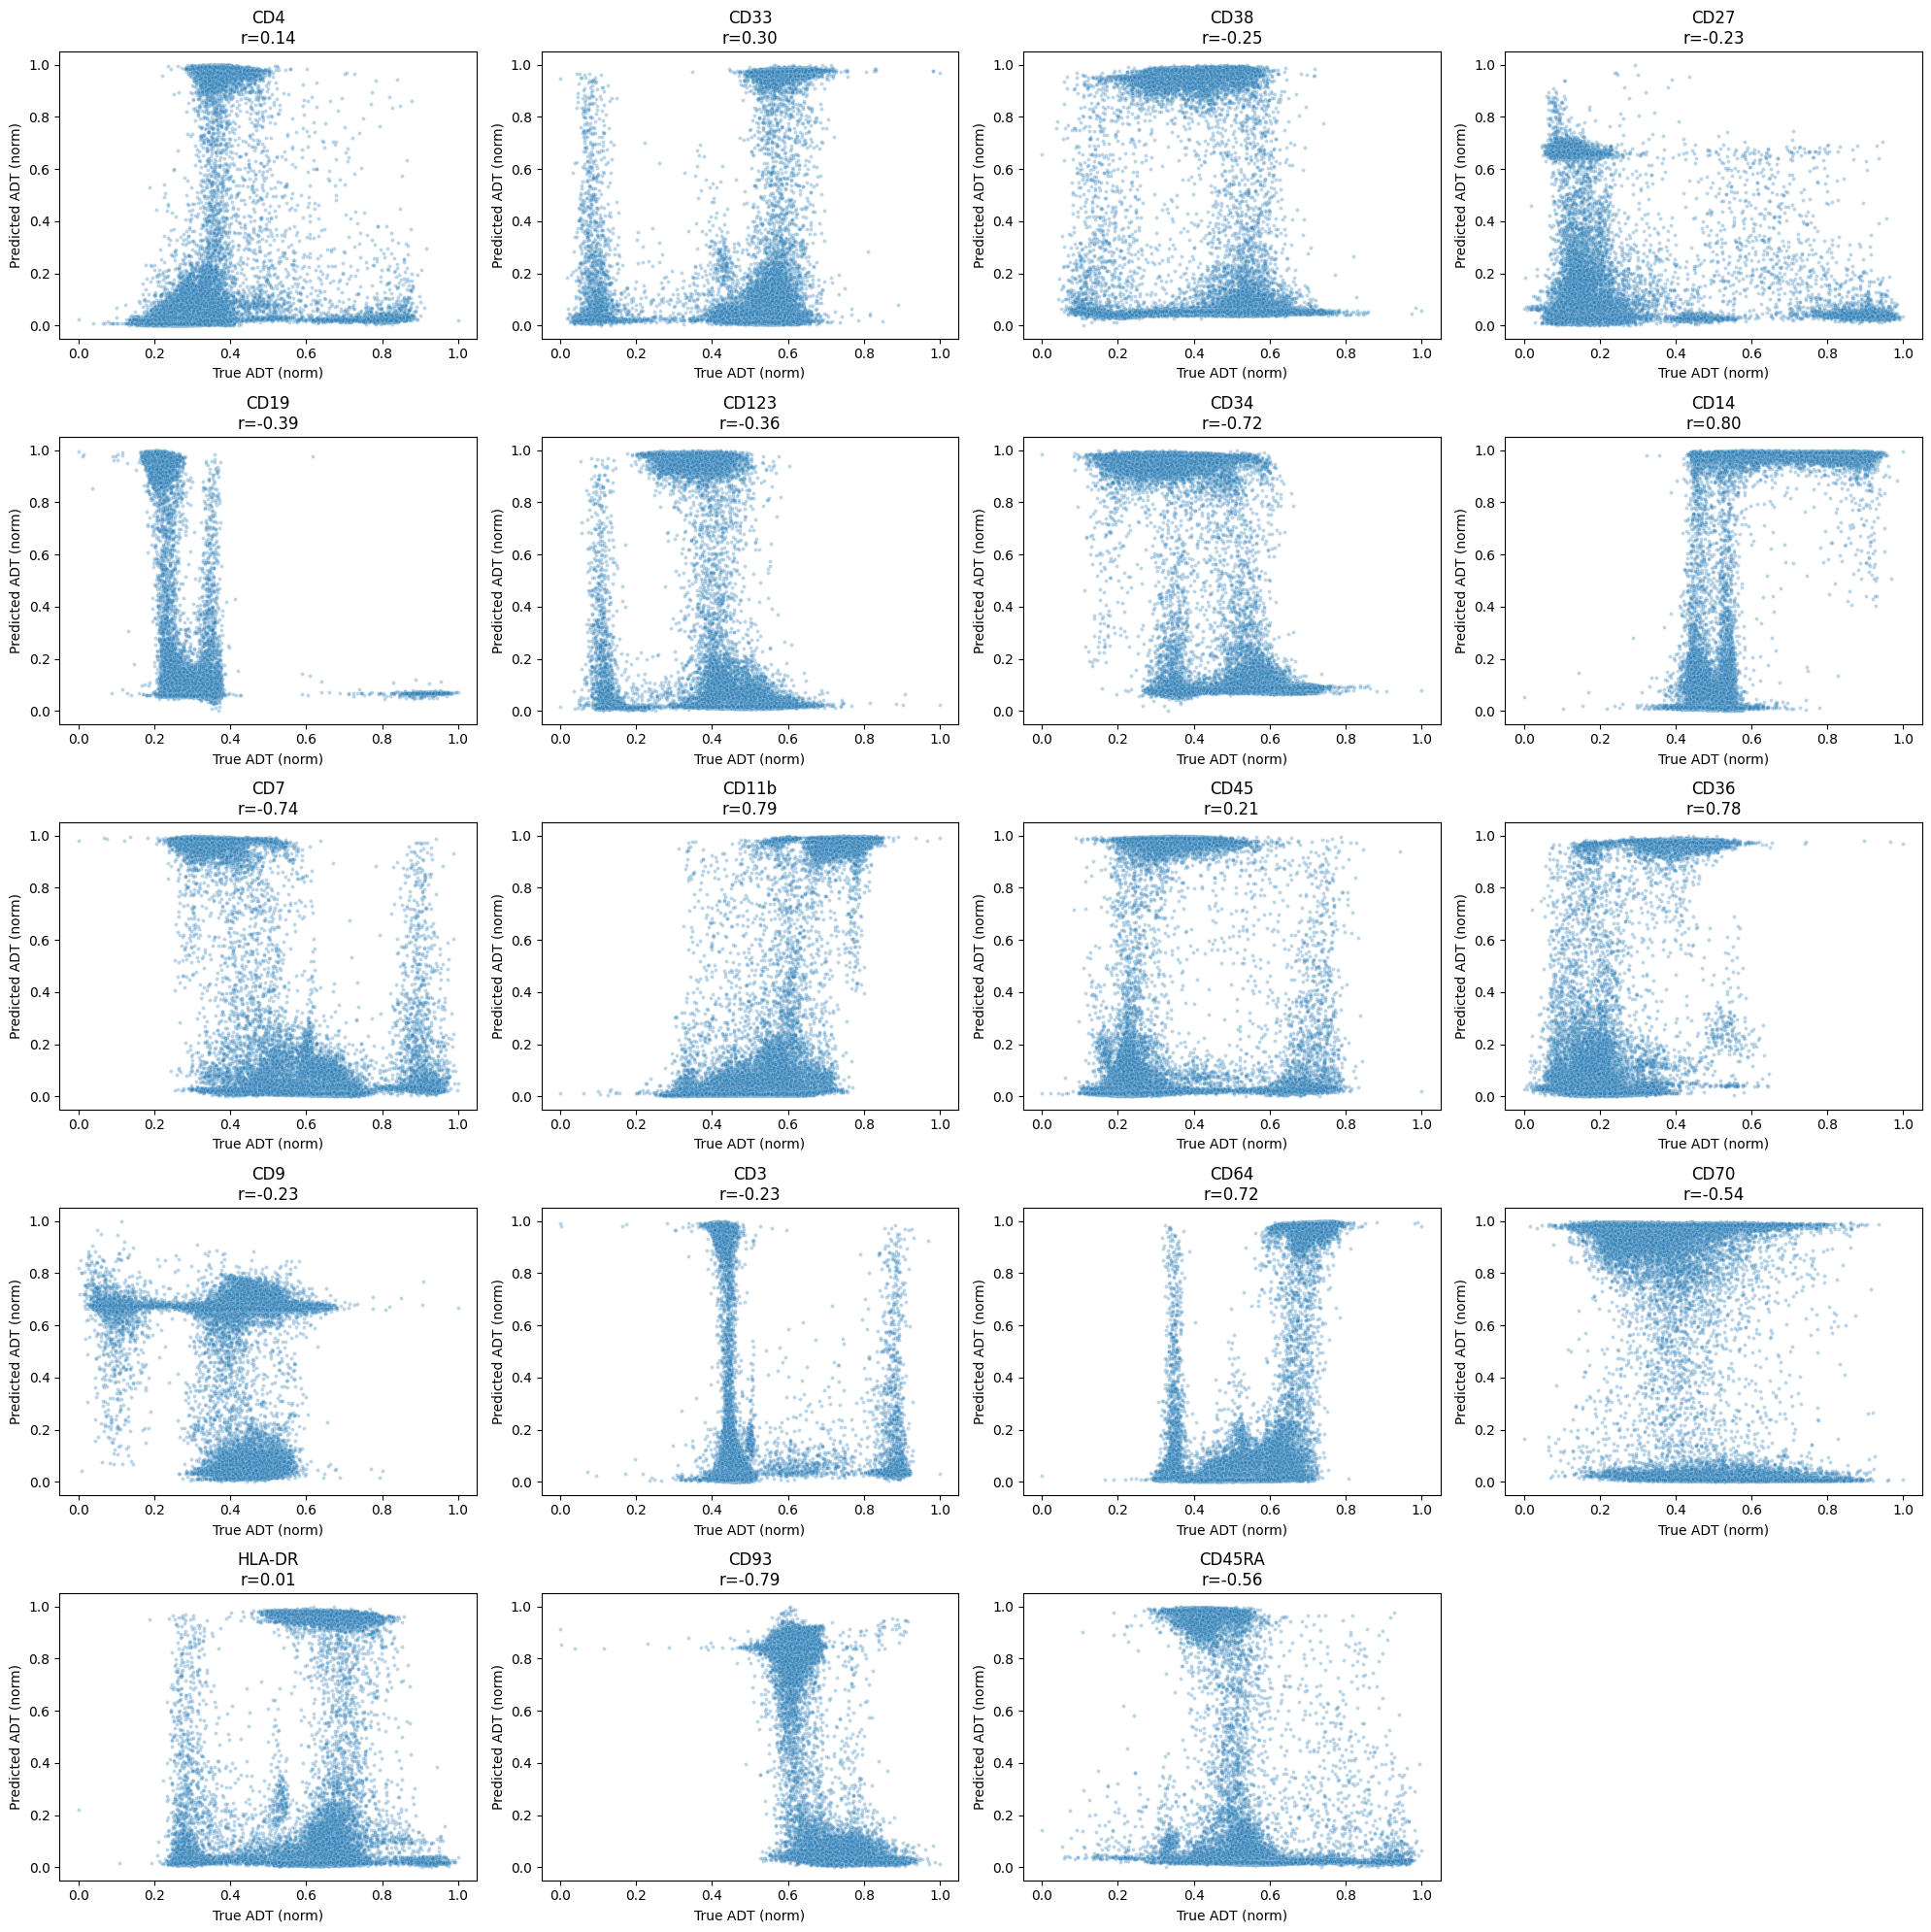

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Find matched columns and common cell indices
common_cols = list(set(true_adt.columns) & set(adt_predictions.columns))
common_idx = list(set(true_adt.index) & set(adt_predictions.index))

# 2. Align both DataFrames by columns and indices
true_aligned = true_adt.loc[common_idx, common_cols]
pred_aligned = adt_predictions.loc[common_idx, common_cols]

# 3. Min-Max normalization to [0, 1]
scaler = MinMaxScaler()
true_norm = pd.DataFrame(scaler.fit_transform(true_aligned), index=true_aligned.index, columns=true_aligned.columns)
pred_norm = pd.DataFrame(scaler.fit_transform(pred_aligned), index=pred_aligned.index, columns=pred_aligned.columns)

# 4. Plot correlation for each matched column
num_cols = len(common_cols)
fig, axes = plt.subplots(nrows=(num_cols + 3) // 4, ncols=4, figsize=(20, 4 * ((num_cols + 3) // 4)))
axes = axes.flatten()

for i, col in enumerate(common_cols):
    sns.scatterplot(
        x=true_norm[col],
        y=pred_norm[col],
        ax=axes[i],
        s=8,
        alpha=0.3
    )
    corr = pd.Series(true_norm[col]).corr(pd.Series(pred_norm[col]))
    axes[i].set_title(f"{col}\nr={corr:.2f}")
    axes[i].set_xlabel("True ADT (norm)")
    axes[i].set_ylabel("Predicted ADT (norm)")

for ax in axes[num_cols:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


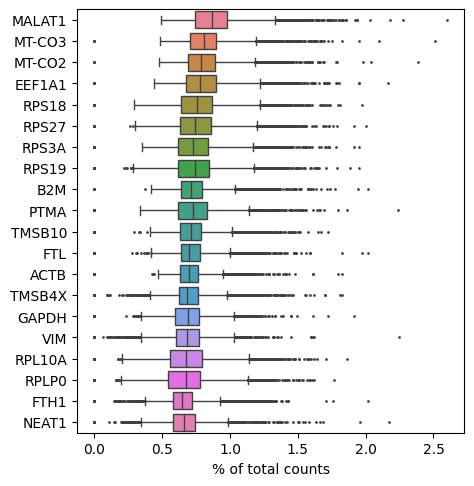

In [21]:
sc.pl.highest_expr_genes(predictions, n_top=20)

Computing PCA from fused embeddings...


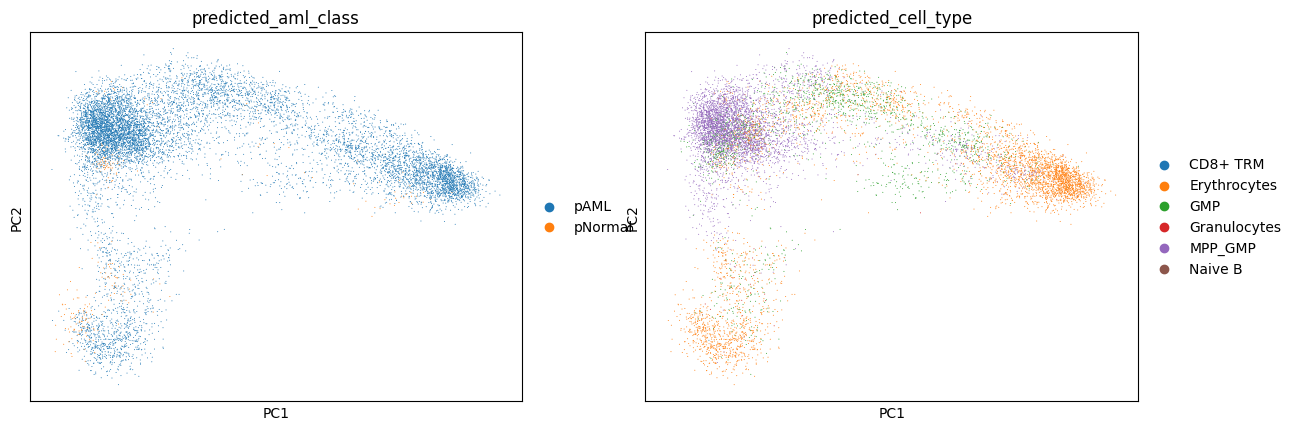

In [29]:
# Compute PCA using fused embeddings
print("Computing PCA from fused embeddings...")

# Store original embeddings
fused_embeddings = predictions.obsm['X_fused_embeddings'].copy()

# Compute PCA using scanpy
sc.pp.pca(predictions, n_comps=50, use_highly_variable=False)

sc.pl.pca(
    predictions,
    color=["predicted_aml_class",'predicted_cell_type'],
    size=2,
)




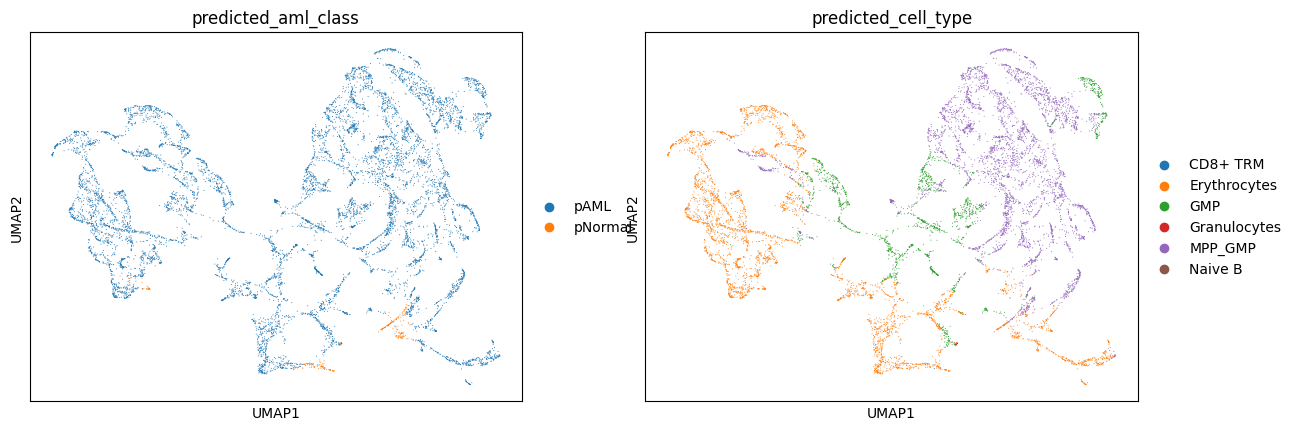

In [32]:

sc.pp.neighbors(predictions, use_rep='X_fused_embeddings')
sc.tl.umap(predictions, min_dist=0.3)

sc.pl.umap(
    predictions,
    color=["predicted_aml_class","predicted_cell_type"],
    size=2,
)

In [25]:
predictions

AnnData object with n_obs × n_vars = 10000 × 2000
    obs: 'sample', 'UMAP_1', 'UMAP_2', 'totalvi_1', 'totalvi_2', 'totalvi_3', 'totalvi_4', 'totalvi_5', 'totalvi_6', 'totalvi_7', 'totalvi_8', 'totalvi_9', 'totalvi_10', 'totalvi_11', 'totalvi_12', 'totalvi_13', 'totalvi_14', 'totalvi_15', 'totalvi_16', 'totalvi_17', 'totalvi_18', 'totalvi_19', 'totalvi_20', '_scvi_batch', '_scvi_labels', 'leiden', 'aml_probability', 'predicted_aml_class'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'pca', 'neighbors', 'leiden', 'predicted_aml_class_colors', 'umap', 'sample_colors'
    obsm: 'X_scVI', 'X_pca', 'X_fused_embeddings', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [21]:
# Extract attention weights
model.eval()
with torch.no_grad():
    attention_dict = model.get_attention_weights(
        x=GSE559.X,
        edge_index_rna=rna_adata.edge_index,
        edge_index_adt=adt_data.edge_index,
        node_degrees_rna=node_degrees_rna,
        node_degrees_adt=node_degrees_adt,
        clustering_coeffs_rna=clustering_coeffs_rna,
        clustering_coeffs_adt=clustering_coeffs_adt
    )

# Visualize specific layer
from scripts.visualizations import visualize_gene_adt_cross_attention

fig, attn_matrix = visualize_gene_adt_cross_attention(
    attention_dict=attention_dict,
    layer_idx=0,  # First transformer layer
    attention_type='rna_to_adt',  # RNA attending to ADT
    num_cells=500,  # Limit number of cells for performance
    save_path='gene_adt_attention_layer0.pdf'
)

# Visualize aggregated gene-marker relationships
from scripts.visualizations import visualize_gene_adt_attention_aggregate

fig, gene_marker_df = visualize_gene_adt_attention_aggregate(
    attention_dict=attention_dict,
    rna_adata=rna_adata,
    adt_adata=adt_adata,
    layer_idx=0,
    attention_type='rna_to_adt',
    top_n_genes=50,
    top_n_markers=30,
    save_path='gene_marker_attention_aggregate.pdf'
)

# Visualize all layers
from scripts.visualizations import visualize_all_transformer_layers

all_figures, attention_dict = visualize_all_transformer_layers(
    model=trained_model,
    rna_data=rna_data.x,
    adt_data=adt_data.x,
    rna_adata=rna_adata,
    adt_adata=adt_adata,
    edge_index_rna=rna_data.edge_index,
    edge_index_adt=adt_data.edge_index,
    save_dir='attention_outputs/'
)

NameError: name 'rna_data' is not defined